# Context Quarantine

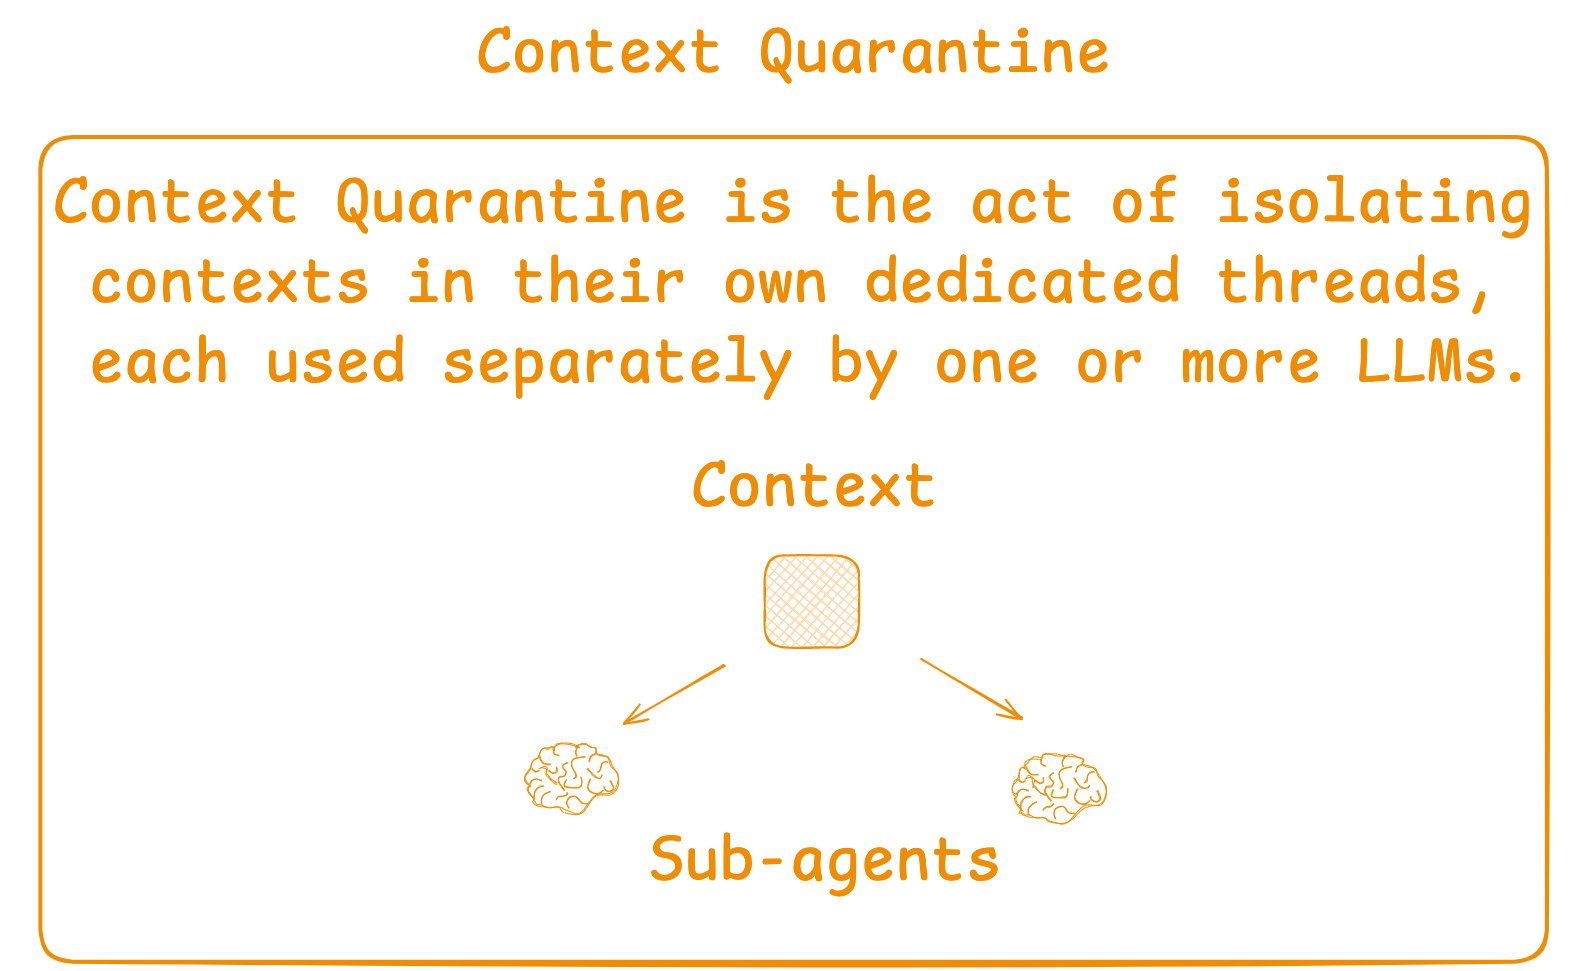

## What it is 

*Context Quarantine is the act of isolating contexts in their own dedicated threads, each used separately by one or more LLMs.*

## Why it helps

* Avoids [Context Clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html): Context clash occours when you accrue new information and tools in your context that conflicts with other information in the prompt. This can occor if a single context window is forced to collect information across a wide range of differening sub-task. Isolating sub-tasks to their own context windows can help. 

* Avoids [Context Distraction](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html): When a context grows so long that the model over-focuses on the context, neglecting what it learned during training. Isolating sub-tasks to their own context windows reduces the number of tokens that each LLM must handle. 

## Context Quarantine in Practice

Anthropic's [multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system) makes a good case for this: many research agents with isolated context windows outperformed single-agent by 90.2%. As the blog said:

> [Subagents operate] in parallel with their own context windows, exploring different aspects of the question simultaneously. 

Of course, the challenge with multi-agent include token use (e.g., [15× more tokens](https://www.anthropic.com/engineering/built-multi-agent-research-system) than chat), the need for careful [prompt engineering](https://www.anthropic.com/engineering/built-multi-agent-research-system) to plan sub-agent work, and - critically - coordination of sub-agents!
 
An important caveat is multi-agent research is *"read‑only"*. As noted by Walden Yan from Cognition [multi-agent systems are less risky if they simply gather ("read") information (e.g., sources) for the main output (e.g., the report) rather than making "writing" (e.g., sections of the report independently)](https://x.com/jxnlco/status/1945490018127987092). Cognition warned against [parallel multi-agent systems](https://cognition.ai/blog/dont-build-multi-agents) that makes many "write" decisions (e.g., part of the final code product, section of th final report) because these can clash when combined. 

### Multi-Agent in LangGraph

LangGraph supports different multi-agent systems. A popular and intuitive way to implement multi-agent is the [supervisor](https://github.com/langchain-ai/langgraph-supervisor-py) architecture, which is what is used in Anthropic's [multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system). 

The LangGraph Supervisor implements a **hierarchical multi-agent architecture** with a central "supervisor" agent that coordinates multiple specialized agents. Here's how it works:

#### Architecture Overview:
- **Supervisor Agent**: Acts as a team manager that routes tasks to appropriate specialized agents
- **Specialized Agents**: Each agent has its own isolated context window and specific capabilities
- **Tool-based Handoff**: Agents communicate through specialized handoff tools, allowing flexible task delegation

#### Key Benefits for Context Quarantine:
1. **Isolated Context Windows**: Each agent operates in its own context, preventing context clash and distraction
2. **Task-Specific Specialization**: Agents focus only on their domain (e.g., math vs. research)
3. **Intelligent Routing**: The supervisor decides which agent to invoke based on the current context and task requirements

#### How Task Delegation Works:
The supervisor uses predefined rules and context understanding to:
- Analyze the incoming request
- Determine which specialized agent is best suited for the task
- Transfer control to that agent with its own clean context
- Collect results and coordinate further actions if needed

This allows the supervisor to delegate tasks to sub-agents, each with their own context window, and then collect the results and make a decision about what to do next. Let's build a supervisor multi-agent system!

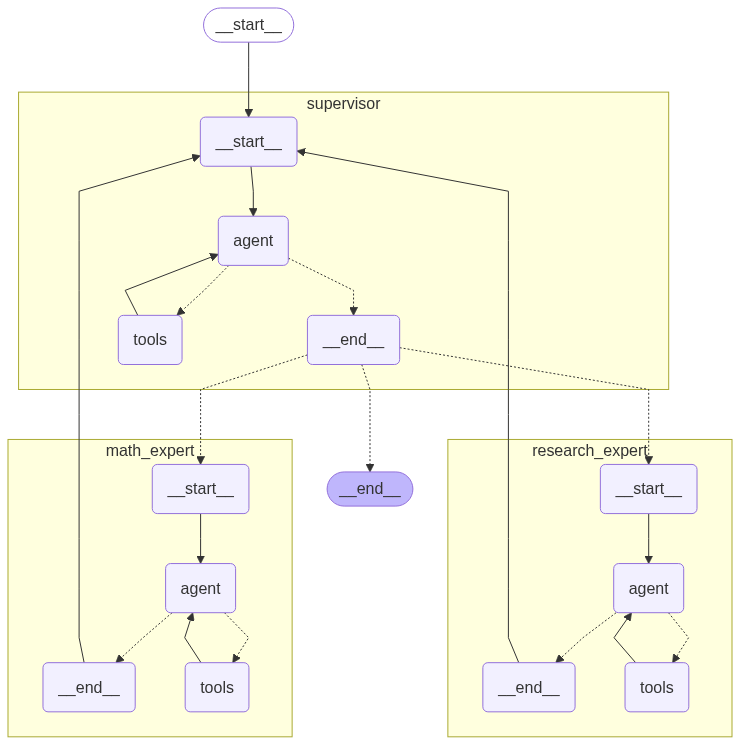

In [1]:
# Import organization and setup
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from IPython.display import Image, display

# Initialize the language model
llm = init_chat_model("openai:gpt-4o", temperature=0)

# Mathematical utility functions
def add(a: float, b: float) -> float:
    """Add two numbers.
    
    Args:
        a: First number to add
        b: Second number to add
        
    Returns:
        Sum of the two numbers
    """
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers.
    
    Args:
        a: First number to multiply
        b: Second number to multiply
        
    Returns:
        Product of the two numbers
    """
    return a * b

# Mock data retrieval function
def web_search(query: str) -> str:
    """Mock web search function that returns FAANG company headcounts.
    
    In a real implementation, this would perform actual web searches.
    Currently returns static 2024 data for demonstration purposes.
    
    Args:
        query: Search query string (unused in this mock implementation)
        
    Returns:
        Formatted string with FAANG company employee headcounts
    """
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

# Improved agent prompts with clear role definitions and constraints
math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply],
    name="math_expert",
    prompt="""You are a specialized mathematics expert with access to addition and multiplication tools.

Your responsibilities:
- Solve mathematical problems using the available tools
- Always use tools for calculations rather than computing mentally
- Use one tool at a time and show your work clearly
- Focus exclusively on mathematical computations

Constraints:
- Do NOT attempt research, web searches, or data gathering
- Do NOT perform calculations without using the provided tools
- Always explain your mathematical reasoning step by step"""
)

research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    name="research_expert",  
    prompt="""You are a specialized research expert with access to web search capabilities.

Your responsibilities:
- Find and retrieve factual information using web search
- Provide comprehensive, well-sourced answers to research questions
- Focus on data gathering and information synthesis

Constraints:
- Do NOT perform mathematical calculations or computations
- Do NOT attempt to solve math problems - delegate those to the math expert
- Always use your search tool to find current, accurate information
- Present findings clearly and cite sources when available"""
)

# Enhanced supervisor prompt with clear delegation strategy
supervisor_prompt = """You are an intelligent team supervisor managing two specialized experts: a research expert and a math expert.

Your role is to:
1. Analyze incoming requests to determine the required expertise
2. Delegate tasks to the appropriate specialist
3. Coordinate between agents when tasks require multiple skills
4. Synthesize results from multiple agents when necessary

Delegation Rules:
- For data gathering, company information, current events, or factual research → use research_agent
- For calculations, mathematical operations, or numerical analysis → use math_agent  
- For complex tasks requiring both research and math → delegate sequentially (research first, then math)

Important: You are a coordinator, not a doer. Always delegate work to your specialists rather than attempting tasks yourself. Never perform calculations or research directly."""

# Create supervisor workflow for coordinating agents
workflow = create_supervisor(
    [research_agent, math_agent],
    model=llm,
    prompt=supervisor_prompt
)

# Compile the multi-agent application
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [2]:
from utils import format_messages
query = "what's the combined headcount of the FAANG companies in 2024?"
result = app.invoke({"messages": [{"role": "user", "content": query}]})
format_messages(result['messages'])

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ what's the combined headcount of the FAANG companies in 2024?                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred to research_expert                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The combined headcount of the FAANG companies in 2024 is as follows:                                            │
│                                                                                                                 │
│ 1. **Facebook (Meta)**: 67,317 employees                                                                        │
│ 2. **Apple**: 164,000 employees                                                                                 │
│ 3. **Amazon**: 1,551,000 employees                                                                              │
│ 4. **Netflix**: 14,000 employees                                                                                │
│ 5. **Google (Alphabet)**: 181,269 employees                                                                     │
│                                                                                                                 │
│ To find the total combined headcount, you would sum these numbers.                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Transferring back to supervisor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred back to supervisor                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred to math_expert                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The combined headcount of the FAANG companies in 2024 is 1,977,586 employees.                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Transferring back to supervisor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred back to supervisor                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The combined headcount of the FAANG companies in 2024 is 1,977,586 employees.                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Looking at the [trace](https://smith.langchain.com/public/526beb15-e208-4bba-b6b5-36bc51d2888b/r), we can see:

* Supervisor delegates the tasks to the research agents.
* Each have their own context window.